### 문제
* 주어진 샘플 개수에 대해 Simple random sampling과 Stratified sampling을 통해 각각 100번씩 average distance를 추정하고 샘플 평균과 샘플 평균의 분산을 계산하는 Python 코드를 작성하시오.
* 샘플 개수를 1000, 2000, 4000, 8000, 16000개로 증가시키면서 두 샘플 방식의 샘플 평균 분산을 그래프로 그리시오 (matplotlib 사용)

### 제출
* 모든 코드와 그래프를 담고 있는 Jupyter Notebook 파일 (.ipynb)

In [1]:
import math

def dist(x1, y1, x2, y2):
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

In [2]:
with open("1000000.txt", "r") as f:
    point_lines = f.readlines()
    point_list = list()
    for line in point_lines:
        t = line.strip().split(',')
        point_list.append((float(t[1]), float(t[2])))

In [3]:
n_points = len(point_list)

In [4]:
n_points

1000000

In [5]:
test_n_samples = [ 1000, 2000, 4000, 8000, 16000 ]

# Simple Random Sampling

In [16]:
import random
import matplotlib.pyplot as plt 

def sample_pair_self(n_points):
    p = random.randrange(0, n_points)
    while True:
        q = random.randrange(0, n_points)
        if q is not p:
            break
    return (p, q)

def srs_average_dist_self(n_points, point_list, n_samples):
    if n_samples == 0:
        return 0
    sum = 0.;
    for _ in range(n_samples):
        p, q = sample_pair_self(n_points)
        sum += dist(point_list[p][0], point_list[p][1], point_list[q][0], point_list[q][1])
    return sum / float(n_samples)

def sample_pair(n_points1, n_points2):
    return (random.randrange(0, n_points1), random.randrange(0, n_points2))

def srs_average_dist(n_points1, point_list1, n_points2, point_list2, n_samples):
    if n_samples == 0:
        return 0
    sum = 0.;
    for _ in range(n_samples):
        p, q = sample_pair(n_points1, n_points2)
        sum += dist(point_list1[p][0], point_list1[p][1], point_list2[q][0], point_list2[q][1])
    return sum / float(n_samples)

def variance_of_sample_means(sample_means):
    m = sum(sample_means) / len(sample_means)
    sse = sum([ (v - m)**2 for v in sample_means ])
    return sse / (len(sample_means) - 1)

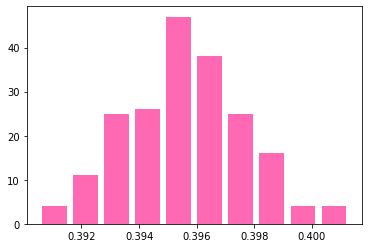

In [51]:
values = [ srs_average_dist_self(n_points, point_list, 10000) for _ in range(200) ]
plt.hist(values, bins=10, cumulative=False, histtype='bar', orientation='vertical', rwidth=0.8,color='hotpink')
plt.show()

In [20]:
res_srs = list()
for n_samples in test_n_samples:
    values = [ srs_average_dist_self(n_points, point_list, n_samples) for _ in range(200) ]
    var = variance_of_sample_means(values)
    res_srs.append(var)

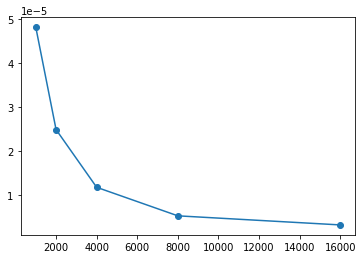

In [21]:
plt.plot( test_n_samples, res_srs, linestyle='-', marker='o')
plt.show()

# Stratified Sampling

In [6]:
with open('1000000.grid', 'r') as grid_file:
    grid_lines = grid_file.readlines() 
    grid_x = [ float(v) for v in grid_lines[0].strip().split(",") ]
    grid_y = [ float(v) for v in grid_lines[1].strip().split(",") ]
    
    # number of points in each grid unit
    grid_size = [ int(v) for v in grid_lines[2].strip().split(",") ]

### Compute strata size and ratio to population size

In [8]:
population_size = n_points * (n_points - 1) / 2

# ratio to population size
strata_ratio = [ 
    [ float(s * t) / float(population_size) if i < j else 0 for j, s in enumerate(grid_size) ]
    for i, t in enumerate(grid_size)
]
for i, s in enumerate(grid_size):
    strata_ratio[i][i] = float(s * (s-1) / 2) / float(population_size)

In [26]:
# flatten
flatten_strata_ratio = [ v for row in strata_ratio for v in row ]
flatten_strata_sample_size = [ v for row in strata_sample_size for v in row ]

### Sample point IDs from each grid unit

1.

With each grid ID i,
* For $S_{ij}$ with all $j \geq i$, sample <code>strata_sample_size[i][j]</code> point IDs from $G_i$ and $G_j$ respectively

2.

Make pairs of points each of which comes from different grid units

3.

With every pair,
* compute distance (refer to broadcast data)
* output distance with strata ID as key

4.

Compute average with each stratum

In [9]:
def get_grid_idx (x, grid_x):
    for idx, excl_max in enumerate(grid_x):
        if x < excl_max:
            return idx

grid_group = [ list() for _ in range(len(grid_size)) ]
for x, y in point_list:
    grid_group[get_grid_idx(x, grid_x) + get_grid_idx(y, grid_y) * len(grid_x)].append((x, y))

# check size
for i, l in enumerate(grid_group):
    assert grid_size[i] == len(l)

In [13]:
def str_average_distance(grid_size, grid_group, strata_ratio, n_sample_size, n_try):
    '''
    Compute average distance using stratified sampling
    
    @params:
    * grid_size: 2-d list for number of points in each grid unit (x-y axis)
    * grid_group: 2-d list of list of points in each grid unit (x-y axis)
    * strata_ratio: 2-d list of strata size ratio over population (stratum id-stratum id axis)
    * n_sample_size: total sample number to select
    * n_try: number of repeat of computing the estimator
    '''
    # e.g., with 1000000.grid, n_grid_units = 16
    n_grid_units = len(grid_size);
    
    # strata sample size allocation
    strata_sample_size = [
        [ round(float(n_sample_size) * strata_ratio[i][j]) for j in range(n_grid_units) ]
        for i in range(n_grid_units)
    ]

    # compute mean of each stratum
    strata_means = [ [ None for _ in range(n_grid_units)] for _ in range(n_grid_units) ]

    for i in range(n_grid_units):
        for j in range(n_grid_units):
            if j == i:
                # sample with replacement
                values = [ srs_average_dist_self(len(grid_group[i]), grid_group[i], strata_sample_size[i][i]) for _ in range(n_try) ]
                strata_means[i][i] = values

            elif j > i:
                values = [ srs_average_dist(len(grid_group[i]), grid_group[i], len(grid_group[j]), grid_group[j], strata_sample_size[i][j]) for _ in range(n_try) ]
                strata_means[i][j] = values
    
    stratified_mean = [ 0. for _ in range(n_try) ]
    for k in range(n_try):
        # compute stratified estimator of distances
        for i in range(n_grid_units):
            for j in range(n_grid_units):
                if j >= i:
                    stratified_mean[k] += strata_ratio[i][j] * strata_means[i][j][k]
    
    return stratified_mean

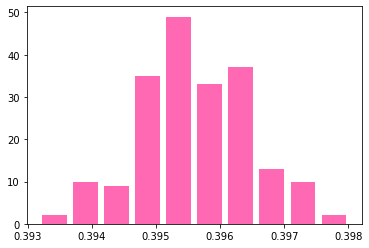

In [17]:
values = str_average_distance(grid_size, grid_group, strata_ratio, 10000, 200)
plt.hist(values, bins=10, cumulative=False, histtype='bar', orientation='vertical', rwidth=0.8,color='hotpink')
plt.show()

In [22]:
res_str = list()
for n_samples in test_n_samples:
    values = str_average_distance(grid_size, grid_group, strata_ratio, n_samples, 200)
    var = variance_of_sample_means(values)
    res_str.append(var)

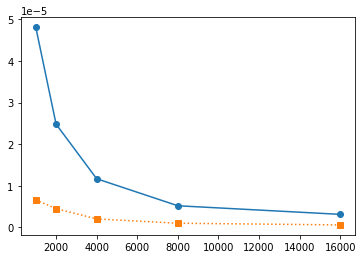

In [23]:
plt.plot( test_n_samples, res_srs, linestyle='-', marker='o')
plt.plot( test_n_samples, res_str, linestyle=':', marker='s')
plt.show()